# Import

In [1]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from PIL import Image
from src.hf_model import Talk2DINO
from torchvision.io import read_image

device = 'cuda:4'

/raid/homes/lorenzo.bianchi/miniconda3/envs/talk2dino_old/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/homes/lorenzo.bianchi/miniconda3/envs/talk2dino_old/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


# Plot Utils

In [2]:
def plot_qualitative(image, sim, palette):
    qualitative_plot = np.zeros((sim.shape[0], sim.shape[1], 3)).astype(np.uint8)

    for j in list(np.unique(sim)):
        qualitative_plot[sim == j] = np.array(palette[j])
    plt.axis('off')
    plt.imshow(image)
    plt.imshow(qualitative_plot, alpha=0.6)
    plt.tight_layout()

# Target Image

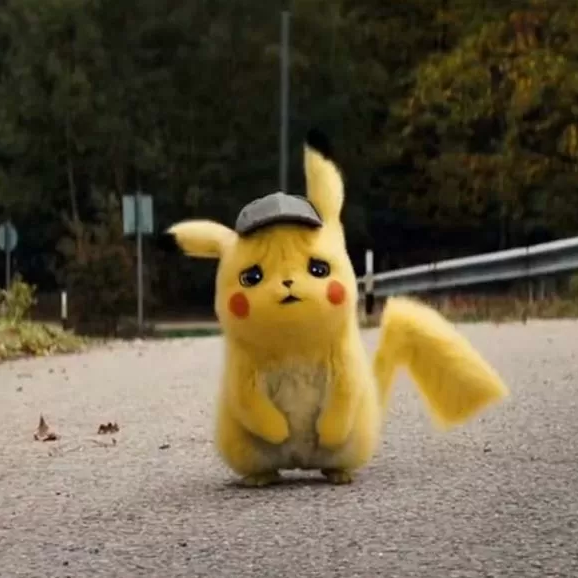

In [3]:
image = Image.open("assets/pikachu.png").convert("RGB")
image

# Model Loading

In [4]:
model = Talk2DINO.from_pretrained("lorebianchi98/Talk2DINO-ViTB").to(device).eval()

Using cache found in /raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main
/raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/raid/homes/lorenzo.bianchi/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


# Mapping Texts & Images in DINOv2 space 

In [5]:
with torch.no_grad():
    text_embed = model.encode_text("a pikachu")
    image_embed = model.encode_image(image)

text_embed.shape, image_embed.shape

/raid/homes/lorenzo.bianchi/miniconda3/envs/talk2dino_old/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


(torch.Size([1, 768]), torch.Size([1, 1369, 768]))

In [6]:
# normalize the features to perform cosine similarity
text_embed = text_embed / text_embed.norm(dim=-1, keepdim=True)
image_embed = image_embed / image_embed.norm(dim=-1, keepdim=True)

similarity = (image_embed @ text_embed.T).squeeze(0, -1).cpu().numpy()

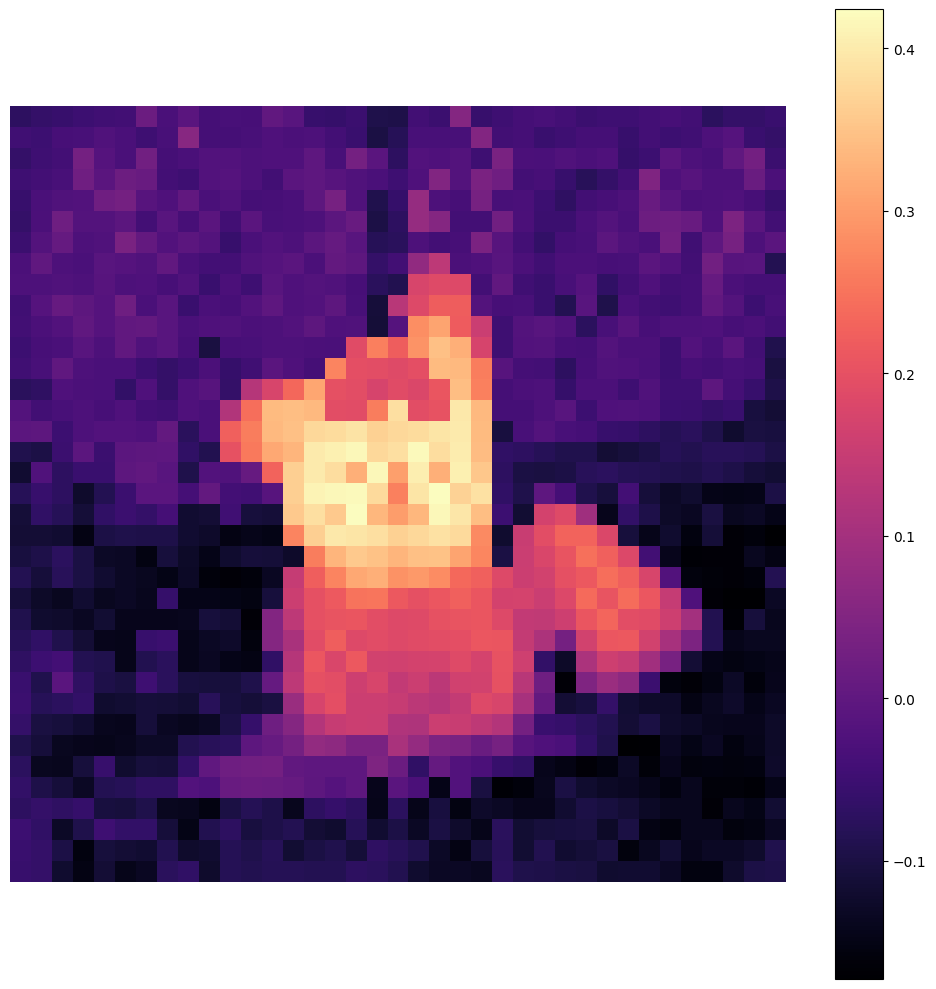

In [7]:
patches_x_row = similarity.shape[0]**0.5
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(similarity.reshape(int(patches_x_row), int(patches_x_row)), cmap='magma')
plt.colorbar()
plt.tight_layout()
plt.show()

# Generate masks

/raid/homes/lorenzo.bianchi/miniconda3/envs/talk2dino_old/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


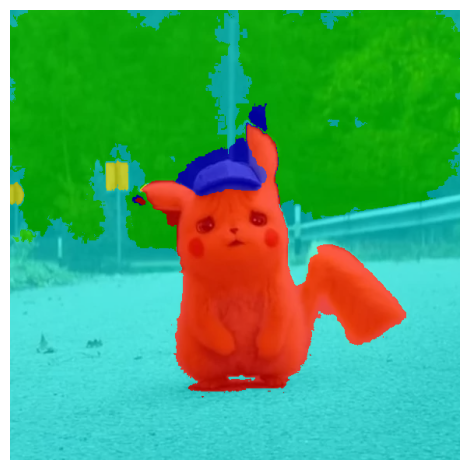

In [8]:
with_background = False
text = "pikachu,traffic_sign,forest,road,cap".replace("_", " ").split(",")
input_file = "assets/pikachu.png"

img = read_image(input_file).to(device).float().unsqueeze(0)
palette = [
    [255, 0, 0],
    [255, 255, 0],
    [0, 255, 0],
    [0, 255, 255],
    [0, 0, 255],
    [128, 128, 128]
]
if len(text) > len(palette):
    for _ in range(len(text) - len(palette)):
        palette.append([np.random.randint(0, 255) for _ in range(3)])
        
if with_background:
    palette.insert(0, [0, 0, 0])
    model.with_bg_clean = True

with torch.no_grad():
    text_emb = model.build_dataset_class_tokens("sub_imagenet_template", text)
    text_emb = model.build_text_embedding(text_emb)
    
    mask, _ = model.generate_masks(img, img_metas=None, text_emb=text_emb, classnames=text, apply_pamr=True)
    if with_background:
        background = torch.ones_like(mask[:, :1]) * 0.55
        mask = torch.cat([background, mask], dim=1)
    
    mask = mask.argmax(dim=1)
    
plot_qualitative(img.cpu()[0].permute(1,2,0).int().numpy(), mask.cpu()[0].numpy(), palette)